Подключим Keras и все необходимые нам модули

In [1]:
import keras
from keras import applications
from keras.utils.vis_utils import model_to_dot
from keras.applications import imagenet_utils
from keras import backend as K
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from skimage.transform import  resize

ImportError: cannot import name 'resize'

In [ ]:
from imageio import imread, imwrite

In [ ]:
sess = K.get_session()
sess.as_default()

In [ ]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

В модуле applications вы сможете найти большое количество предтренированных моделей. Загрузим уже знакомый нам VGG16, обученный на Imagenet

In [ ]:
# build the VGG16 network
K.clear_session()
model = applications.VGG16(include_top=True,
                           weights='imagenet')

В Keras существуют удобные средства для визуализации моделей. 

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
image = imread('image_1.jpg')https://distill.pub/2017/feature-visualization/

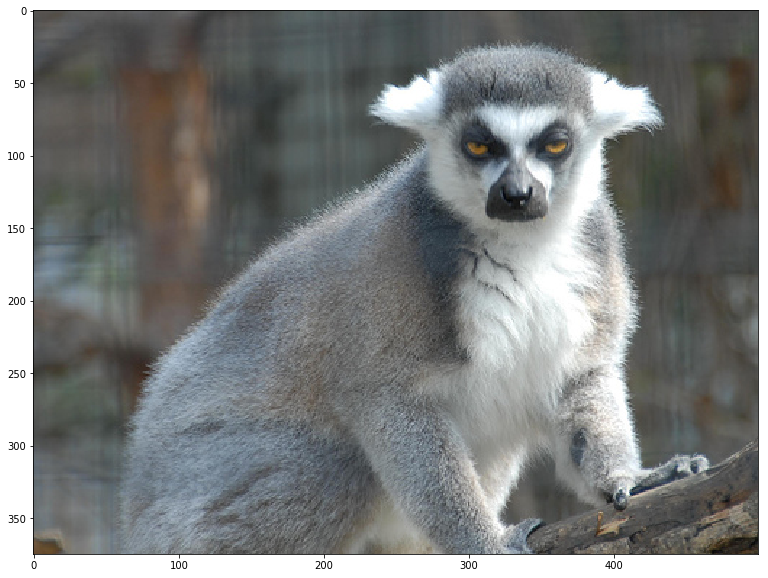

In [10]:
plt.imshow(image)

In [11]:
resized_image = resize(image, (224, 224), mode='wrap', preserve_range=True)
y = model.predict(np.expand_dims(resized_image, 0))

In [12]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [13]:
imagenet_utils.decode_predictions(y)

[[('n02497673', 'Madagascar_cat', 0.93312687),
  ('n02500267', 'indri', 0.062328555),
  ('n02493509', 'titi', 0.001560853),
  ('n02494079', 'squirrel_monkey', 0.0009420697),
  ('n02486261', 'patas', 0.00064214296)]]

In [14]:
def build_train_function(class_index = 0):
    # Получаем тензор, отвечающий за вход модели
    input_img = model.input
        
    # Выберем нужный слой
    predictions = model.output
    probabilities = K.softmax(predictions)
    objective = K.log(probabilities + 1e-8)[:,class_index]
    
    # Вызываем метод бэкенда, рассчитывающий градиент
    grads = K.gradients(objective, input_img)[0]

    # Оборачиваем всё это в специальную абстракцию,
    # которая скрывает вызов сессии TF
    return K.function([input_img], [grads, objective])

In [3]:
K.function??

In [15]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
def compute_image(train_function, img, max_iter = 50, lr = 1, epsilon = 5.0):
    input_img_data = img.copy()
    
    below = img - epsilon
    above = img + epsilon
    
    for i in range(max_iter):
        grads_value, objective_value = train_function([input_img_data])
        grads_value /= grads_value.std()+1e-8    
        input_img_data += grads_value * lr
        input_img_data = np.clip(np.clip(input_img_data, below, above), 0, 255)
        
        print(f'objective: {np.mean(objective_value):.2}', end='\r')
    
    input_img_data = input_img_data[0]
    return input_img_data.astype(np.uint8)
#     return deprocess_image(input_img_data)

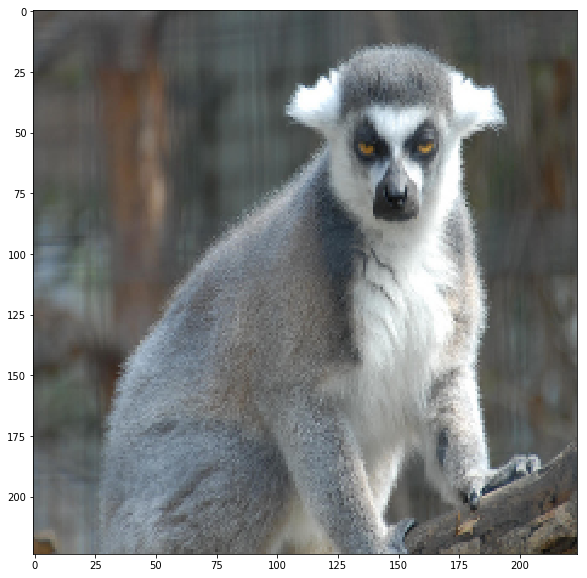

In [17]:
plt.imshow(resized_image.astype(np.uint8))

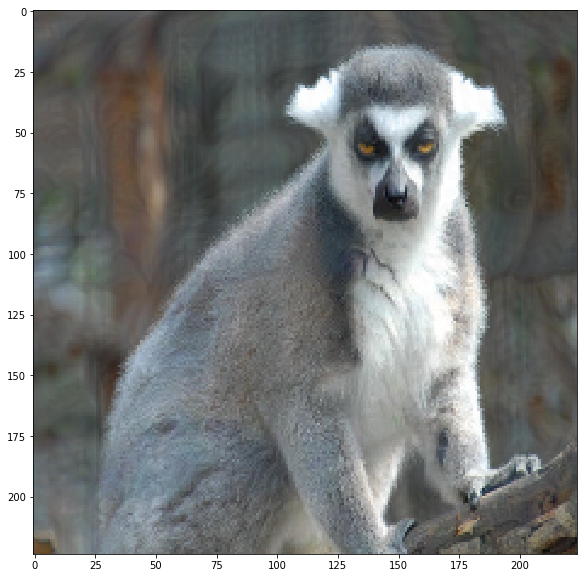

In [18]:
train_function = build_train_function(965)
img = compute_image(train_function, lr=1, img= np.expand_dims(resized_image, 0), epsilon=3.0)
plt.imshow(img)

In [19]:
y = model.predict(np.expand_dims(img, 0))
imagenet_utils.decode_predictions(y)

[[('n07880968', 'burrito', 0.9999993),
  ('n07583066', 'guacamole', 1.9342339e-07),
  ('n03887697', 'paper_towel', 1.4856418e-07),
  ('n07697537', 'hotdog', 1.0354887e-07),
  ('n07860988', 'dough', 6.0696664e-08)]]

In [20]:
from scipy.ndimage.interpolation import shift, rotate

In [21]:
rotated = rotate(img, np.degrees(np.pi/8), reshape=False)

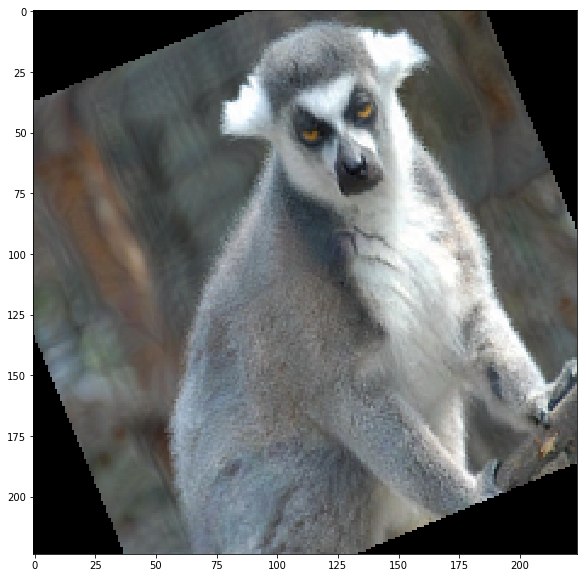

In [22]:
plt.imshow(rotated)

In [24]:
y = model.predict(np.expand_dims(rotated, 0))
imagenet_utils.decode_predictions(y)

[[('n02497673', 'Madagascar_cat', 0.2601706),
  ('n02138441', 'meerkat', 0.15613876),
  ('n03958227', 'plastic_bag', 0.11063484),
  ('n03887697', 'paper_towel', 0.07729186),
  ('n07880968', 'burrito', 0.065617524)]]

In [25]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [26]:
def build_train_function_robust(class_index = 0, num_samples = 20):
    # Получаем тензор, отвечающий за вход модели
    input_img = K.placeholder(shape=(1, 224,224,3))
            
    objectives = []
    for _ in range(num_samples):
        angle = K.random_uniform((), minval=-np.pi/4, maxval=np.pi/4)
        rotated = tf.contrib.image.rotate(input_img, angles=angle)
        output = model(rotated)
        probabilities = K.softmax(output)
        neg_xent = K.log(probabilities + 1e-8)[:,class_index]
        objectives.append(neg_xent)
        
    
    objective = K.mean(neg_xent)
    
    # Вызываем метод бэкенда, рассчитывающий градиент
    grads = K.gradients(objective, input_img)[0]

    # Оборачиваем всё это в специальную абстракцию,
    # которая скрывает вызов сессии TF
    return K.function([input_img], [grads, objective])

Instructions for updating:
Use the retry module or similar alternatives.


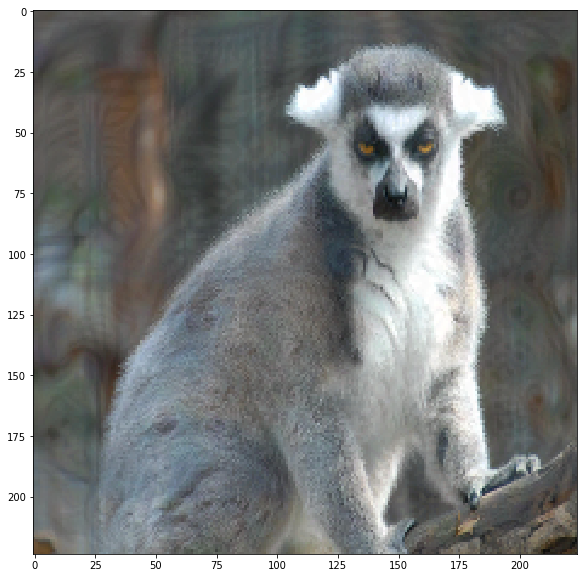

In [27]:
train_function = build_train_function_robust(965)
img = compute_image(train_function, lr=1, img= np.expand_dims(resized_image, 0), epsilon=3.5)
plt.imshow(img)

In [28]:
y = model.predict(np.expand_dims(img, 0))
imagenet_utils.decode_predictions(y)

[[('n07880968', 'burrito', 0.996243),
  ('n07860988', 'dough', 0.00048827313),
  ('n02100735', 'English_setter', 0.00037011417),
  ('n07930864', 'cup', 0.00016525605),
  ('n03958227', 'plastic_bag', 0.00014925982)]]

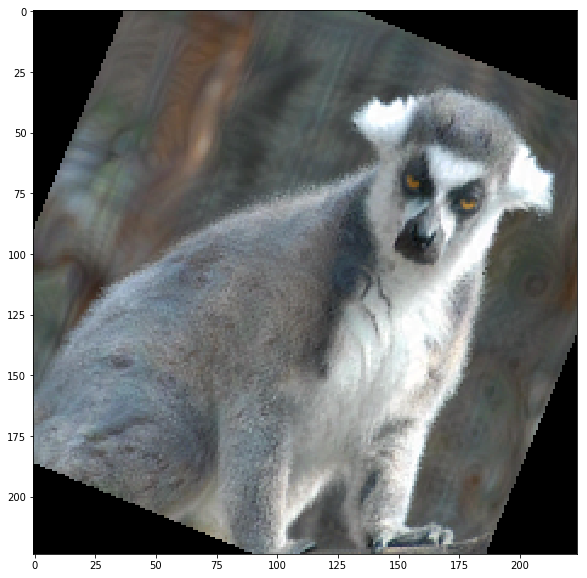

In [29]:
rotated = rotate(img, - np.degrees(np.pi/8), reshape=False)
plt.imshow(rotated)

In [30]:
y = model.predict(np.expand_dims(rotated, 0))
imagenet_utils.decode_predictions(y)

[[('n07880968', 'burrito', 0.9999951),
  ('n07860988', 'dough', 1.1747262e-06),
  ('n03887697', 'paper_towel', 7.5549616e-07),
  ('n03958227', 'plastic_bag', 4.3035584e-07),
  ('n15075141', 'toilet_tissue', 3.9441426e-07)]]